# Поиск ковид-диссидентов в VK 
####  Исследовательский проект

## Цель:
> Собрать список ковид-диссидендов и проверить как меняется отношенние к вирусу с течением времени

## План:
> 1. Сбор постов из вк (см. DATA_COLLECTION.ipynb)
> 2. Сбор комметариев к постам связанным с вирусом (см. DATA_COLLECTION.ipynb)
> 3. Тематическое моделирование, выявление ковид и антиковид тем.
> 4. Подсчет для каждого пользователя количества ковид и антиковид тем в срезе дней.
> 5. Поиск пользователей, которые с течением времение сменили позицию с ковид-диссидентов, на не-ковид-диссидентов.

In [1]:
import nltk
import re
import numpy as np
import pandas as pd
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from pymystem3 import Mystem
m = Mystem()



from nltk.corpus import stopwords
# russian_stopwords = stopwords.words("russian")# собираем стоп слова

def lemmatize_sentence(text):
    text=str(text)
    lemmas = m.lemmatize(text)
    return "".join(lemmas).strip()
# nltk.download("stopwords")

In [2]:
with open('data/stop-ru-words.txt', 'r') as f:
    russian_stopwords = [line.strip() for line in f]


Возможность использовать данные из DB. Но для удобства показа, выгрузил в cvs

In [3]:
# import import_ipynb
# from dbControllerPsql import DataBase
# db=DataBase(port=54320)
# comments=db.getFromTable('comments','text, user_id',"")

In [4]:
df=pd.read_csv('data/comments.csv') 
df=df[['user_id','text']]
df

,user_id,text
0,356567315,ждём вторую волну господа...
1,50242365,Ураааа))
2,118429745,"Всё, собираем чемоданы!"
3,390491791,"Машки и Наташки полетели на ""массаж"" к джабраи..."
4,138802909,"А потом из за таких любителей отдохнуть, пол г..."
...,...,...
241989,596993003,Уже никто не комментирует эту х...ю
241990,1284915,Вчера вы эту важнейшую информацию выложили в 1...
241991,10374092,Да срать все уже хотели на этот вирус. Куда ин...
241992,78974118,"Как вы зае...и, маску купи анализ сук сдай за ..."


## EDA

Делаем лемматизацию сообщений

In [5]:
df['text_new'] = df['text'].apply(lambda x: (lemmatize_sentence(x)))

In [6]:
df

,user_id,text,text_new
0,356567315,ждём вторую волну господа...,ждать второй волна господин...
1,50242365,Ураааа)),ураааа))
2,118429745,"Всё, собираем чемоданы!","все, собирать чемодан!"
3,390491791,"Машки и Наташки полетели на ""массаж"" к джабраи...","машка и наташка полететь на ""массаж"" к джабраи..."
4,138802909,"А потом из за таких любителей отдохнуть, пол г...","а потом из за такой любитель отдыхать, пол год..."
...,...,...,...
241989,596993003,Уже никто не комментирует эту х...ю,уже никто не комментировать этот х...ю
241990,1284915,Вчера вы эту важнейшую информацию выложили в 1...,вчера вы этот важный информация выкладывать в ...
241991,10374092,Да срать все уже хотели на этот вирус. Куда ин...,да срать все уже хотеть на этот вирус. куда ин...
241992,78974118,"Как вы зае...и, маску купи анализ сук сдай за ...","как вы зае...и, маска купить анализ сук сдават..."


Удаляем лишние символы

In [7]:
data = df.text_new.values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
pprint(data[:1])

['ждать второй волна господин...']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['ждать', 'второи', 'волна', 'господин']]


In [9]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in russian_stopwords] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        print(sent)
        text=''.join([str(elem) for elem in sent]) 
        lemmas = m.lemmatize(text)
        print("text:")
        print(text)
        print("lemmas:")
        print(lemmas)
    
        
        break
    return texts_out


def lemmatization_(text):
    text=str(text)
    lemmas = m.lemmatize(text)
    return "".join(lemmas).strip()



In [10]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

bigram_mod = gensim.models.phrases.Phraser(bigram)

# Удаляем стоп слова

data_words_nostops = remove_stopwords(data_words)
# Подготаввливаем биграмы из очищенных данных
data_words_bigrams = make_bigrams(data_words_nostops)


In [11]:
data_words_bigrams

[['ждать', 'второи_волна', 'господин'],
 ['ураааа'],
 ['собирать_чемодан'],
 ['машка', 'наташка', 'полететь', 'массаж', 'джабраил', 'окзон', 'бгг'],
 ['такои',
  'любитель',
  'отдыхать',
  'пол',
  'ходить',
  'маска',
  'ребенок',
  'домашнии',
  'обучение',
  'далее',
  'надоедать',
  'цирк'],
 ['ждать', 'гость', 'ковид'],
 ['чума', 'монголия', 'завозить', 'дом'],
 ['правильныи'],
 ['ага',
  'битком',
  'забивать',
  'грязныи',
  'сочи',
  'крым',
  'ничто',
  'завозить',
  'заграница',
  'прямои',
  'заразныи',
  'идиотизм',
  'крепчать'],
 ['руззка', 'шлюжок', 'собирать_чемодан'],
 [],
 ['снизу',
  'блокпост',
  'корововирус',
  'летать',
  'главное',
  'хоккеиныи',
  'игра',
  'зритель'],
 ['народ', 'улица', 'валиться', 'кв', 'заипацца'],
 ['турция', 'сеичас', 'раи'],
 ['голодныи', 'нишие', 'полететь', 'тиран', 'путин'],
 ['открываться', 'сторона', 'страна', 'снг'],
 ['нга', 'маска'],
 ['урааа', 'зарабатывать'],
 ['коронавирус'],
 ['id_евгении', 'пачка', 'прямои', 'падать', 'ага'

In [12]:
data_lemmatized=data_words_bigrams


In [13]:
# Подготавливаем словарь
id2word = corpora.Dictionary(data_words_bigrams)

id2word.filter_extremes(no_above=0.7)
print(id2word)
texts = data_words_bigrams
# Подготавливаем корпус
corpus = [id2word.doc2bow((text)) for text in texts]


Dictionary(21041 unique tokens: ['второи_волна', 'господин', 'ждать', 'ураааа', 'собирать_чемодан']...)


In [14]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('второи_волна', 1), ('господин', 1), ('ждать', 1)]]

## Моделирование

__Подбираем оптимальное количество топиков по конгерентности__

In [15]:
from gensim.models.ldamulticore import LdaMulticore

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=num_topics)
        print("Ineration {}".format(num_topics))
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [17]:
limit=40; start=4; step=1;

In [18]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

Ineration 4
Ineration 5
Ineration 6
Ineration 7
Ineration 8
Ineration 9
Ineration 10
Ineration 11
Ineration 12
Ineration 13
Ineration 14
Ineration 15
Ineration 16
Ineration 17
Ineration 18
Ineration 19
Ineration 20
Ineration 21
Ineration 22
Ineration 23
Ineration 24
Ineration 25
Ineration 26
Ineration 27
Ineration 28
Ineration 29
Ineration 30
Ineration 31
Ineration 32
Ineration 33
Ineration 34
Ineration 35
Ineration 36
Ineration 37
Ineration 38
Ineration 39


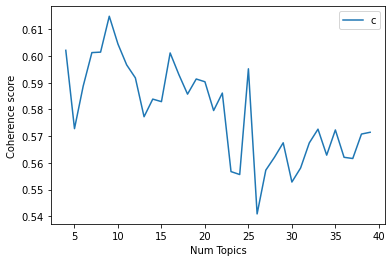

In [19]:

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
max=0
for m, cv in zip(x, coherence_values):
    if(max<round(cv, 4)):
        max=round(cv, 4)
        num=m-start
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
print("Coherence {}. Topic number {}".format(max,num))

Num Topics = 4  has Coherence Value of 0.6021
Num Topics = 5  has Coherence Value of 0.5728
Num Topics = 6  has Coherence Value of 0.5887
Num Topics = 7  has Coherence Value of 0.6013
Num Topics = 8  has Coherence Value of 0.6015
Num Topics = 9  has Coherence Value of 0.6149
Num Topics = 10  has Coherence Value of 0.6045
Num Topics = 11  has Coherence Value of 0.5967
Num Topics = 12  has Coherence Value of 0.5918
Num Topics = 13  has Coherence Value of 0.5773
Num Topics = 14  has Coherence Value of 0.5839
Num Topics = 15  has Coherence Value of 0.5829
Num Topics = 16  has Coherence Value of 0.6012
Num Topics = 17  has Coherence Value of 0.5931
Num Topics = 18  has Coherence Value of 0.5857
Num Topics = 19  has Coherence Value of 0.5914
Num Topics = 20  has Coherence Value of 0.5904
Num Topics = 21  has Coherence Value of 0.5796
Num Topics = 22  has Coherence Value of 0.5861
Num Topics = 23  has Coherence Value of 0.5568
Num Topics = 24  has Coherence Value of 0.5557
Num Topics = 25  ha

In [21]:

optimal_model=model_list[num]

In [22]:

pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.010*"nan" + 0.008*"такои" + 0.007*"россия" + 0.007*"говорить" + '
  '0.006*"самоизоляция" + 0.005*"вакцина" + 0.005*"дом" + 0.005*"сделать" + '
  '0.005*"работать" + 0.005*"вирус"'),
 (1,
  '0.006*"россия" + 0.006*"хорошии" + 0.005*"сеичас" + 0.005*"молодец" + '
  '0.005*"умирать" + 0.005*"слово" + 0.004*"вирус" + 0.004*"народ" + '
  '0.004*"nan" + 0.004*"такои"'),
 (2,
  '0.020*"вирус" + 0.007*"россия" + 0.007*"закрывать" + 0.007*"умирать" + '
  '0.007*"карантин" + 0.007*"скоро" + 0.006*"коронавирус" + 0.006*"какои" + '
  '0.006*"такои" + 0.006*"другои"'),
 (3,
  '0.031*"маска" + 0.011*"какои" + 0.010*"сидеть" + 0.009*"каждыи" + '
  '0.008*"вирус" + 0.008*"пусть" + 0.008*"такои" + 0.007*"дома" + '
  '0.006*"ходить" + 0.005*"носить"'),
 (4,
  '0.012*"врач" + 0.011*"какои" + 0.008*"работа" + 0.008*"сеичас" + '
  '0.008*"москва" + 0.006*"которыи" + 0.006*"знать" + 0.006*"работать" + '
  '0.006*"поити" + 0.006*"маска"'),
 (5,
  '0.009*"которыи" + 0.009*"делать" + 0.008*"работать

In [23]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.010386  0.010734       1        1  14.626370
4      0.024860  0.022777       2        1  13.476176
3      0.029657  0.016863       3        1  12.434205
5      0.020331  0.007451       4        1  12.241015
8      0.018949  0.043543       5        1  10.416159
2      0.004973  0.048382       6        1  10.291706
6      0.015833 -0.026345       7        1  10.090712
0      0.022345 -0.118810       8        1   8.326363
1     -0.147336 -0.004594       9        1   8.097295, topic_info=           Term          Freq         Total Category  logprob  loglift
106         nan  12246.000000  12246.000000  Default  30.0000  30.0000
11        маска  11849.000000  11849.000000  Default  29.0000  29.0000
67        вирус  11007.000000  11007.000000  Default  28.0000  28.0000
16      ребенок   6111.000000   6111.000000  Default  27.0000  27.0000
491      деньги   7051.000000   7051.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
1503      пусть    399.815877   4693.090993   Topic9  -5.8572   0.0508
215   закрывать    391.741938   4245.987292   Topic9  -5.8776   0.1305
132     которыи    439.935106   9801.989060   Topic9  -5.7616  -0.5901
87     больница    388.470304   5045.107809   Topic9  -5.8860  -0.0503
11        маска    386.450420  11849.815319   Topic9  -5.8912  -0.9094

[831 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
2004       1  0.003899           be
2004       2  0.023395           be
2004       4  0.003899           be
2004       7  0.003899           be
2004       9  0.963105           be
...      ...       ...          ...
4071       8  0.923560         шуба
17139      5  0.959346     эволюция
11788      6  0.942752  эгоистичныи
1884       4  0.956302          эхо
17939      4  0.963329      ярмарка

[2936 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 4, 6, 9, 3, 7, 1, 2])

## Вывод

К сожалению выделить семантику сообщений не представляется возможным, как следствие дальнейшее исследование не возможно

### Возможное решение

Подготовить данные и отдать в какой-либо сервис для разметки, и уже на размеченных данных обучать модель и искать необходимые комментарии